# Task 1: we will train a machine learning model to be able to classify pieces of text in a set of documents into different categories like warnings, ingredients, description, legal info, etc. 
- step 1: figure out how to feauturize pieces of text in vector space.
    - first lets use a premade dataset of natural language data to figure some things out. 
    - gensim will allow us to encode words as vectors and documents as vectors (lists of words as vectors). 

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('movie_data.csv')
df.head()

pos = df[df.sentiment == 1].shape[0]
neg = df[df.sentiment == 0].shape[0]

print(pos, neg)

25000 25000


In [3]:
import gensim #gensim will be used for document / word embedding. 

In [4]:
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize 
from gensim.models.doc2vec import Doc2Vec

In [5]:
def trim_s(s):
    s = s.lower()
    s = s.replace('\n', ' ')
    s = s.replace('<br />', ' ')
    s = s.replace(',', ' ')
    s = s.replace('.', ' ')
    s = s.replace('-', ' ')
    s = s.replace('(', ' ')
    s = s.replace(')', ' ')
    s = s.replace("'", ' ')
    s = s.replace("''",  ' ')
    s = s.replace(' in ', ' ')
    s = s.replace(' on ', ' ')
    s = s.replace(' a ', ' ')
    s = s.replace(' an ', ' ')
    s = s.replace(' the ', ' ')
    s = s.replace(' in ', ' ')
    s = s.replace(' about ', ' ')
    s = s.replace(' in ', ' ')
    s = s.replace(' by ', ' ')
    s = s.replace(' is ', ' ')
    s = s.replace(' was ', ' ')
    return s

In [6]:
#some of this code modified from https://www.geeksforgeeks.org/python-word-embedding-using-word2vec/
sample = df['review']
sample_data = []
#ind = 0
n = df['review'].values.size
for s in  df['review'].values:
    #print(ind / n)
    #ind += 1
    s = trim_s(s)
    for i in sent_tokenize(s):
        temp = []
        for j in word_tokenize(i):
            temp.append(j.lower())
        sample_data.append(temp)


In [7]:
from gensim.models.doc2vec import TaggedDocument
from gensim.test.utils import get_tmpfile

In [36]:
docs = [TaggedDocument(doc, [i]) for i, doc in enumerate(sample_data)]
#dm = 1 preserves order of text in the document
doc_model = Doc2Vec(docs, vector_size=100, window=4, min_count=1, workers=10, dm=1)

In [9]:
import tensorflow as tf
import numpy as np

In [10]:
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.layers import Input, Dense, Activation, Dropout
from keras.models import Sequential
from keras.models import Model

Using TensorFlow backend.


In [37]:
train_len = int(3*n/4)
test_len = int(n/4)
#valid_len = int(n/4)

X_train, y_train = df['review'].values[0:train_len], df['sentiment'].values[0:train_len]
X_test, y_test = df['review'].values[train_len:train_len + test_len], df['sentiment'].values[train_len:train_len + test_len]
#X_valid, y_valid = df['review'].values[train_len + test_len : train_len + test_len + valid_len], df['sentiment'].values[train_len + test_len : train_len + test_len + valid_len]
for i in range(len(X_train)):
    X_train[i] = trim_s(X_train[i])
for j in range(len(X_test)):
    X_test[j] = trim_s(X_test[j])

TrainingSet = []
for xi in X_train:
    vec = doc_model.infer_vector(str(xi).split())
    TrainingSet.append(vec)
TestingSet = []
for xi in X_test:
    vec1 = doc_model.infer_vector(str(xi).split())
    TestingSet.append(vec1)

In [38]:
#try standardizing with a MinMaxScaler, seems to lead to overfittting for some reason. 
from sklearn import preprocessing
TrainingSet = np.array(TrainingSet)
TestingSet = np.array(TestingSet)
#mms = preprocessing.MinMaxScaler()
#TrainingSet = mms.fit_transform(TrainingSet)
#TestingSet = mms.transform(TestingSet)
#standardizing with MaxAbsScaler doesn't do much damage but still doesn't really seem to help accuracy that much if at all. 
#mma = preprocessing.MaxAbsScaler()
#TrainingSet = mma.fit_transform(TrainingSet)
#TestingSet = mma.transform(TestingSet)
from sklearn.svm import SVC
clf = SVC(C=1.5, kernel='rbf', verbose=True)
clf.fit(TrainingSet, y_train)
yhats = clf.predict(TestingSet)

from sklearn.metrics import accuracy_score
accuracy_score(y_test, yhats)

C:\Users\tsmar\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[LibSVM]

0.82048

In [13]:
import keras
import numpy as np
import cv2
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.preprocessing import image
from keras.layers import MaxPooling2D
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Dropout

In [39]:
model = Sequential()
model.add(Dense(8, input_dim=100, activation='tanh', init='uniform'))
model.add(Dense(8, activation='tanh', init='uniform'))
model.add(Dense(1, activation='sigmoid', init='uniform'))

C:\Users\tsmar\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, input_dim=100, activation="tanh", kernel_initializer="uniform")`
  
C:\Users\tsmar\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="tanh", kernel_initializer="uniform")`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\tsmar\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  after removing the cwd from sys.path.


In [40]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [41]:
model.fit(TrainingSet, y_train, epochs=10, verbose=1)
scores = model.evaluate(TestingSet, y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Epoch 1/10
37500/37500 [==============================] - 2s 40us/step - loss: 0.4560 - acc: 0.8031
Epoch 2/10
37500/37500 [==============================] - 1s 31us/step - loss: 0.4135 - acc: 0.8202
Epoch 3/10
37500/37500 [==============================] - 1s 31us/step - loss: 0.4124 - acc: 0.8209
Epoch 4/10
37500/37500 [==============================] - 2s 44us/step - loss: 0.4123 - acc: 0.8213
Epoch 5/10
37500/37500 [==============================] - 1s 37us/step - loss: 0.4121 - acc: 0.8213
Epoch 6/10
37500/37500 [==============================] - 1s 31us/step - loss: 0.4119 - acc: 0.8199
Epoch 7/10
37500/37500 [==============================] - 1s 30us/step - loss: 0.4115 - acc: 0.8203
Epoch 8/10
37500/37500 [==============================] - 1s 30us/step - loss: 0.4103 - acc: 0.8216
Epoch 9/10
37500/37500 [==============================] - 1s 30us/step - loss: 0.4092 - acc: 0.8214
Epoch 10/10
12500/12500 [==============================] - 0s 20us/step

acc: 81.60%


# Results:
- SVM and NN get about 81%
- Naive Bayes and NN get 70-72%
- when PCA is used only a few percent accuracy is lost for much faster calculation, PCA embedded data is actualy better for naive bayes

In [17]:
import sklearn.decomposition
pca = sklearn.decomposition.PCA(n_components=10)
pca.fit(TrainingSet)
pTrain = pca.transform(TrainingSet)
pTrain[0]

pTest = pca.transform(TestingSet)

In [18]:
from sklearn.naive_bayes import GaussianNB
gauss_naive_bayes = GaussianNB([0.5, 0.5])
gauss_naive_bayes.fit(pTrain, y_train)
y_pred = gauss_naive_bayes.predict(pTest)

r_pca = accuracy_score(y_test, y_pred)
print(r_pca)

0.6932


In [19]:
from sklearn.neighbors import KNeighborsClassifier
clf_nn = KNeighborsClassifier(n_neighbors=3, weights='distance', algorithm='ball_tree')
clf_nn.fit(pTrain, y_train)
yh = clf_nn.predict(pTest)

accuracy_score(y_test, yh)

0.72984

In [27]:
model2 = Sequential()
model2.add(Dense(8, input_dim=10, activation='tanh', init='uniform'))
model2.add(Dense(8, activation='tanh', init='uniform'))
model2.add(Dense(1, activation='sigmoid', init='uniform'))

model2.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

model2.fit(pTrain, y_train, epochs=20)
scores = model2.evaluate(pTest, y_test)
print("\n%s: %.2f%%" % (model2.metrics_names[1], scores[1]*100))

C:\Users\tsmar\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, input_dim=10, activation="tanh", kernel_initializer="uniform")`
  
C:\Users\tsmar\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="tanh", kernel_initializer="uniform")`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\tsmar\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  after removing the cwd from sys.path.


Epoch 1/20
37500/37500 [==============================] - 3s 68us/step - loss: 0.5062 - acc: 0.7726
Epoch 2/20
37500/37500 [==============================] - 1s 36us/step - loss: 0.4763 - acc: 0.7833
Epoch 3/20
37500/37500 [==============================] - 1s 35us/step - loss: 0.4760 - acc: 0.7835
Epoch 4/20
37500/37500 [==============================] - 1s 36us/step - loss: 0.4759 - acc: 0.7837
Epoch 5/20
37500/37500 [==============================] - 2s 40us/step - loss: 0.4760 - acc: 0.7818
Epoch 6/20
37500/37500 [==============================] - 1s 38us/step - loss: 0.4759 - acc: 0.7827
Epoch 7/20
37500/37500 [==============================] - 2s 47us/step - loss: 0.4758 - acc: 0.7828
Epoch 8/20
37500/37500 [==============================] - 2s 42us/step - loss: 0.4756 - acc: 0.7831
Epoch 9/20
37500/37500 [==============================] - 2s 41us/step - loss: 0.4758 - acc: 0.7842
Epoch 10/20
37500/37500 [==============================] - 1s 36us/step - loss: 0.4758 - acc: 0.7837

# Clustering

In [28]:
from sklearn.cluster import KMeans

In [29]:
kmeans = KMeans(n_clusters=2).fit(pTrain)

In [30]:
kmeans.predict(pTest)

array([0, 0, 1, ..., 0, 0, 0])

In [31]:
accuracy_score(kmeans.predict(pTest), y_test)

0.58256

# Visualization

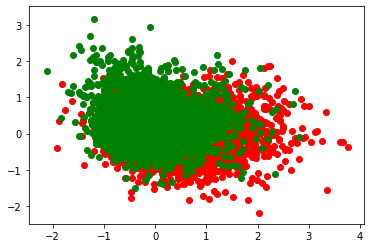

In [32]:
import matplotlib.pyplot as plt

pca2 = sklearn.decomposition.PCA(n_components=2)
pca2.fit(TrainingSet)
pTrain2 = pca2.transform(TrainingSet)
pTest2 = pca2.transform(TestingSet)

x1_pos = []
x1_neg = []
x2_pos = []
x2_neg = []
for i, point in enumerate(pTrain2):
    if y_train[i] == 1:
        x1_pos.append(point[0])
        x2_pos.append(point[1])
    else:
        x1_neg.append(point[0])
        x2_neg.append(point[1])


plt.scatter(x1_pos, x2_pos, color='r')
plt.scatter(x1_neg, x2_neg, color='g')
plt.show()

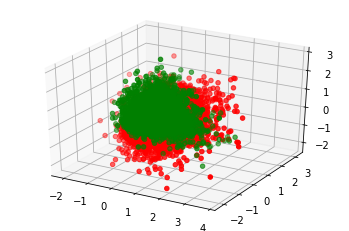

In [33]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


pca3 = sklearn.decomposition.PCA(n_components=3)
pca3.fit(TrainingSet)
pTrain3 = pca3.transform(TrainingSet)
pTest3 = pca3.transform(TestingSet)

x1_pos = []
x1_neg = []
x2_pos = []
x2_neg = []
x3_pos = []
x3_neg = []
for i, point in enumerate(pTrain3):
    if y_train[i] == 1:
        x1_pos.append(point[0])
        x2_pos.append(point[1])
        x3_pos.append(point[2])
    else:
        x1_neg.append(point[0])
        x2_neg.append(point[1])
        x3_neg.append(point[2])

ax.scatter(x1_pos, x2_pos, x2_pos, c='r')
ax.scatter(x1_neg, x2_neg, x3_neg, c='g')